In [19]:
%matplotlib inline

from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import StratifiedKFold
# from sklearn.base import clone

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [2]:
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [4]:
X, y = mnist['data'], mnist['target']

In [4]:
display(X.shape)
display(y.shape)

(70000, 784)

(70000,)

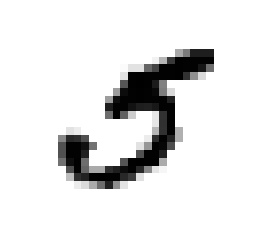

In [7]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [8]:
y[36000]

5.0

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Binary

In [13]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [10]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict(some_digit.reshape(1, -1))

array([ True])

In [12]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96645, 0.94585, 0.9611 ])

In [13]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never5_clf = Never5Classifier()
cross_val_score(never5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91035, 0.91115, 0.90745])

In [15]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
confusion_matrix(y_train_5, y_train_pred)

array([[53382,  1197],
       [ 1335,  4086]], dtype=int64)

In [17]:
precision_score(y_train_5, y_train_pred)

0.7734241908006815

In [18]:
recall_score(y_train_5, y_train_pred)

0.7537354731599336

In [19]:
f1_score(y_train_5, y_train_pred)

0.7634529147982063

In [20]:
display(sgd_clf.decision_function([X[0]]))
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([98071.42294042])

array([98071.42294042])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([ True])

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [23]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

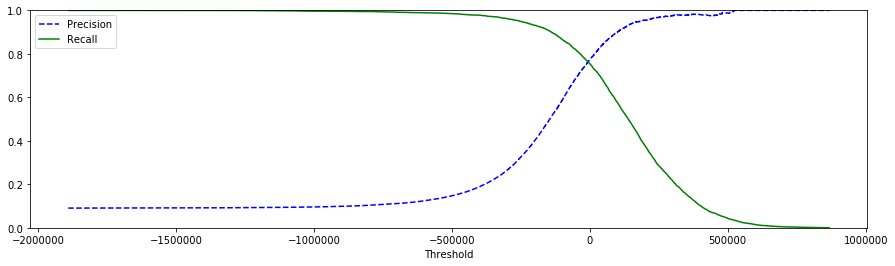

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    
plt.figure(figsize=(15, 4))    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)    
plt.show()    

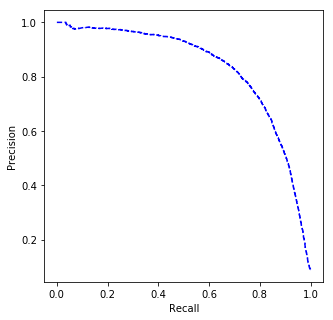

In [25]:
plt.figure(figsize=(5, 5))  
plt.plot(recalls[:-1], precisions[:-1], "b--", label="Precision vs Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show() 

In [26]:
y_train_pred_90 = (y_scores>70000)

In [27]:
precision_score(y_train_5, y_train_pred_90)

0.8710579857578841

In [28]:
recall_score(y_train_5, y_train_pred_90)

0.6318022505072864

In [29]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

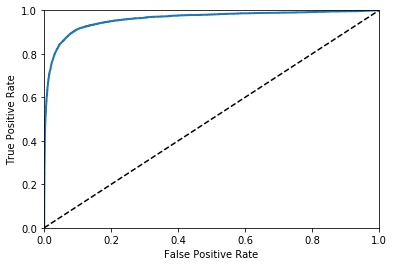

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr, tpr)
plt.show()

In [31]:
roc_auc_score(y_train_5, y_scores)

0.9603190065902619

In [32]:
rf_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [33]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

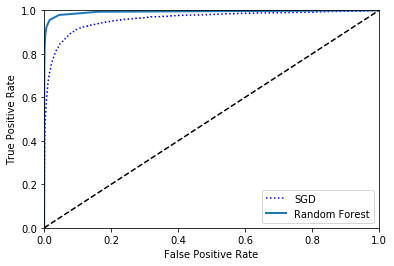

In [34]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931860979469218

In [36]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

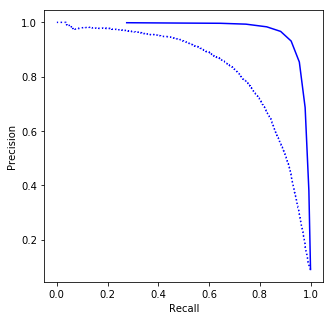

In [37]:
plt.figure(figsize=(5, 5))  
plt.plot(recalls[:-1], precisions[:-1], "b:", label="SGD")
plt.plot(recalls_forest[:-1], precisions_forest[:-1], "b-", label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show() 

### Multiclass

In [38]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int16)

In [39]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-398282.89920755, -485507.1541107 , -242543.98230081,
          57086.34394443, -647629.75391364,   87711.76027876,
        -559317.21453082, -383728.24661362, -301043.9858465 ,
        -571489.81357214]])

In [40]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([3], dtype=int16)

In [41]:
len(ovo_clf.estimators_)

45

In [42]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int16)

In [43]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [44]:
cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring='accuracy')

array([0.88021658, 0.87235461, 0.88291667, 0.87246812, 0.86512171])

In [45]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.9140172 , 0.90724536, 0.90803621])

In [46]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5741,    2,   22,    9,    9,   45,   43,    9,   38,    5],
       [   2, 6472,   44,   28,    6,   43,    6,   14,  116,   11],
       [  57,   36, 5359,   96,   80,   27,   85,   55,  147,   16],
       [  50,   37,  145, 5343,    1,  238,   35,   54,  129,   99],
       [  22,   27,   38,    6, 5383,    8,   49,   31,   82,  196],
       [  71,   45,   33,  184,   75, 4622,  105,   29,  169,   88],
       [  37,   24,   45,    1,   48,   88, 5623,    3,   48,    1],
       [  25,   22,   77,   30,   49,   12,    4, 5788,   15,  243],
       [  60,  150,   81,  158,   14,  165,   54,   23, 4991,  155],
       [  46,   30,   26,   90,  181,   38,    3,  216,   78, 5241]],
      dtype=int64)

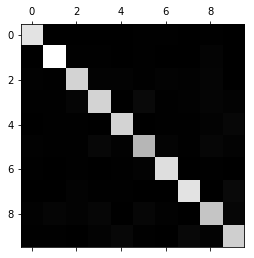

In [47]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

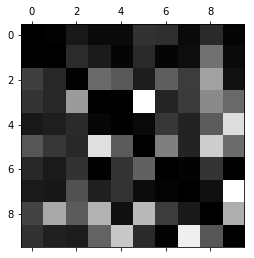

In [48]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### Multilabel

In [49]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [50]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average='macro')

### Multioutput

In [7]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

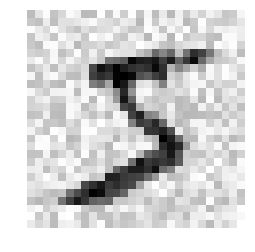

In [12]:
plt.imshow(X_train_mod[0].reshape(28, 28), cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

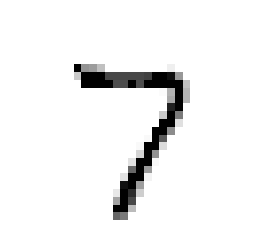

In [22]:
clean_digit = knn_clf.predict([X_test_mod[0]])
plt.imshow(clean_digit.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

## Excercises

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on
the test set. Hint: the KNeighborsClassifier works quite well for this task; you just
need to find good hyperparameter values (try a grid search on the weights and
n_neighbors hyperparameters).

In [14]:
knn_clf = KNeighborsClassifier()
# knn_clf.fit(X_train, y_train_5)
cross_val_score(knn_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.99335, 0.9935 , 0.99435])

In [ ]:
param_grid = {'weights':['uniform', 'distance'], 'n_neighbors':[5, 50, 500]}

knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train, y_train_5)